# Code Space for Debugging of Plotter Code

In [154]:
import base64
import os, io
from datetime import date, datetime, timedelta
import pandas as pd
import seaborn as sns
from windrose import WindroseAxes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from PIL import Image
import numpy as np
import google.cloud.logging
from google.cloud import storage
import logging
from alive_progress import alive_bar

In [155]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../service_account.json'

### Create Date Range 

In [156]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----- ----- ----- -----    CREATE DATERANGE    ----- ----- ----- -----
# Create list of all dates between start_date and end_date
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

# ======================================================================

### Truncate CMAP

In [157]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----- ----- ----- -----   TRUNCATE COLORMAP    ----- ----- ----- -----
# Can be used to remove white / black bookended values
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
          'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
          cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# ======================================================================

### Plot Temps

In [158]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----- ----- ----- -----      PLOT TEMPS        ----- ----- ----- -----
# Saves each plot to date specific folder in Google Cloud bucket
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def plot_temps(storage_client, locations=[], date=datetime.today().date(), days=[], save_name=''):
    
    # Loop through each graph type to plot
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for d in days:
        # Set figure details
        # ~~~~~~~~~~~~~~~~~~
        plt.figure(figsize=(20,6))
        plt.xlim([0, d -1])
        plt.grid()
        plt.axhline(0, color='black')
        plt.xticks(rotation = 'vertical')
        if d > 30:
            plt.xticks(np.arange(0, d+1, 7.0))  

        if len(locations) == 1:
            plt.title("{} Temperature °C - {} day".format(locations[0]['name'], d))
        else:
            plt.title("Temperature °C - {} day".format(d))

        palette = sns.color_palette("Paired", n_colors=6)
        palette_order = [1, 0, 3, 2, 5, 4]
        palette = [palette[idx] for idx in palette_order]
        hue_order = [850, 700]

        # Loop through each location and plot data on graph
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        for location in locations:
            # Create truncated data object with only correct date range
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            mask = (location['data']['Date'] >= str(date - timedelta(days=d))) & (location['data']['Date'] <= str(date))
            plot_data = location['data'].loc[mask]
            
            #print(plot_data)

            # Add data for single location to graph
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            if not plot_data.empty:
                g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=plot_data, palette=palette[location['palette_order'][0]: location['palette_order'][1]], hue_order=hue_order)
            else:
                print('Empty dataframe - cannot plot')


        # Rename legend with detailed labels
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        l = plt.legend()
        labels = []
        for location in locations:
            for pressure in [700, 850]:
                labels.append('{} {}'.format(location['name'], pressure))

        # Re-order labels by desc pressure
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        if len(locations) == len(palette_order) / 2:
            labels = [labels[idx] for idx in palette_order]
        else:
            labels = ['850', '700']
        for x, label in enumerate(labels):
            l.get_texts()[x].set_text(label)

        # Generate Save Path
        # ~~~~~~~~~~~~~~~~~~
        if not save_name:
            save_name = '{}_temp'.format(locations[0]['name'].lower().replace(' ', ''))

        save_loc = "./figures/temp/{}".format(date.strftime("%Y/%m/%d"))

        if not os.path.isdir(save_loc):
            os.makedirs(save_loc)

        # Publish graph to Google Cloud
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        bucket_name = 'weather_aurorabc'
        bucket = storage_client.bucket(bucket_name)

        buff = io.BytesIO()
        plt.savefig(buff, format='webp',dpi=150, bbox_inches="tight")

        blob_name = 'graphs/{}/{}_{}d_{}.webp'.format(date.strftime("%Y/%m/%d"), save_name, d, date.strftime("%Y/%m/%d"))
        blob = bucket.blob(blob_name)
        blob.upload_from_string(buff.getvalue(), content_type='image/png')
        plt.close()
        del buff

# ======================================================================

### Plot Wind

In [159]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----- ----- ----- -----       PLOT WIND        ----- ----- ----- -----
# Saves each plot to date specific folder in Google Cloud bucket
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def plot_wind(storage_client, location, date=datetime.today().date(), days=[]):
    
    # Define color map and truncate to apropriate range
    cmap = cm.viridis_r
    cmap = truncate_colormap(cmap, minval=0, maxval=0.9)
  
    # Loop through each graph type to plot
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for d in days:
        # Create truncated data object with only correct date range
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        try:
            mask = (location['data']['Date'] > str(date - timedelta(days=d))) & (location['data']['Date'] <= str(date))
            plot_data = location['data'].loc[mask]
        except Exception as e:
            print(e)

        # Continue to next loop if df is empty
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        if plot_data.empty:
            print('Empty dataframe - cannot plot')
            continue

        # Populate speed and direction vars from DataFrame
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
        wd = plot_data['Wind_Direction'].to_list()
        ws = plot_data['Wind_Speed'].to_list()


        # Plot wind rose for data set
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~
        ax = WindroseAxes.from_ax()
        #ax.contourf(wd, ws, bins=np.arange(0, 100, 10), cmap=cmap)
        ax.contourf(wd, ws, cmap=cmap)
        ax.set_legend()

        # Save figure
        # ~~~~~~~~~~~
        plt.title("{} Wind - {} day".format(location['name'], d))
        plt.legend(title="Wind Speed (km/h)", loc=4, fontsize='small', fancybox=True)

        # Generate Save Path
        # ~~~~~~~~~~~~~~~~~~
        save_name = '{}_wind'.format(location['name'].lower().replace(' ', ''))

        save_loc = "./figures/wind/{}".format(date)

        if not os.path.isdir(save_loc):
            os.makedirs(save_loc)

        # Save image as webp
        # ~~~~~~~~~~~~~~~~~~
        path = '{}/{}_{}d_{}'.format(save_loc, save_name, d, date)
        plt.savefig('{}.webp'.format(path), format='webp',dpi=150)

        # Publish graph to Google Cloud
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        bucket_name = 'weather_aurorabc'
        bucket = storage_client.bucket(bucket_name)

        buff = io.BytesIO()
        plt.savefig(buff, format='webp',dpi=150, bbox_inches="tight")

        blob_name = 'graphs/{}/{}_{}d_{}.webp'.format(date, save_name, d, date)
        blob = bucket.blob(blob_name)
        blob.upload_from_string(buff.getvalue(), content_type='image/png')
        plt.close()
        del buff

# ======================================================================

### Patch missing values in dataset

In [160]:
def patch_dataset(data):
    # Create Date Range
    start_date = data.iloc[0]['Date']
    end_date = data.iloc[-1]['Date']
    
    dates = daterange(datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d'))

    
    stations = ['Quillayute', 'Vernon', 'Port Hardy']
    pressures = [700, 850]
    # Itterate through date range
    for date in dates:
        for station in stations:
            for pressure in pressures:
                # If data is missing, add empty values
                if data[(data['Date'] == date.strftime("%Y-%m-%d")) & (data['Station'] == station) & (data['Pressure'] == pressure)].empty:
                    #print("Missing data for {}:\n\tDate:{}\n\tPressure:{}\n".format(station, date.strftime("%Y-%m-%d"), pressure))
                    new_row = {
                        'Date': date.strftime("%Y-%m-%d"), 
                        'Station': station, 
                        'Pressure': pressure, 
                        'Height': np.nan,
                        'Temp': np.nan,
                        'DewPoint': np.nan,
                        'Relative_Humidity': np.nan,
                        'Mean_Mixed_Layer': np.nan,
                        'Wind_Direction': np.nan,
                        'Wind_Speed': np.nan,
                        'Potential_Temp': np.nan,
                        'Equivalent_Potential_Temp': np.nan,
                        'Virtual_Potential_Temp': np.nan}
                    
                    data.loc[len(data)] = new_row

    # Return complete data
    print("Patching Complete")
    return data.sort_values(by=['Date', 'Station', 'Pressure'])

### Import Weather Data

In [161]:
def import_weather_data():
    # Connect to Google Cloud Storage
    # -------------------------------
    storage_client = storage.Client()

    # Open Bucket
    # -----------
    bucket_name = 'weather_aurorabc'
    bucket = storage_client.bucket(bucket_name)

    # Open Blob
    # ---------
    blob_name = 'weather.csv'
    blob = bucket.blob(blob_name)

    # Read Weather Data from Blob
    # ---------------------------
    with blob.open("r") as f:
        weather_data = pd.read_csv(f)

    # Cast all data variables to float
    weather_data = weather_data.astype(
        {'Height':'float',
        'Temp':'float',
        'DewPoint':'float',
        'Relative_Humidity':'float',
        'Mean_Mixed_Layer':'float',
        'Wind_Direction':'float',
        'Wind_Speed':'float',
        'Potential_Temp':'float',
        'Equivalent_Potential_Temp':'float',
        'Virtual_Potential_Temp':'float',
        })
    
    try:
        weather_data = patch_dataset(weather_data)
    except Exception as e:
        print("Error patching dataset")
        print(e)
        
    return weather_data
    

### Main Application Body

In [162]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 
# ----- ----- ----- -----          START         ----- ----- ----- -----
#  + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def main():
    
    weather_data = import_data()


    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # DEFINE PLOT ATTRIBITES FOR EACH LOCATION
    #logging.info("Defining plots for each locaiton")
    print("Defining plots for each locaiton")
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    locations = [{
        'name': "Vernon",
        'palette_order': [2, 4], # green
        'save_name': "vernon",
        'data': weather_data[weather_data['Station'] == "Vernon"]
    },
    {
        'name': "Port Hardy",
        'palette_order': [4, 6], # red
        'save_name': "porthardy",
        'data': weather_data[weather_data['Station'] == "Port Hardy"]
    },
    {
        'name': "Quillayute",
        'palette_order': [0, 2], # blue
        'save_name': "quillayute",
        'data': weather_data[weather_data['Station'] == "Quillayute"]
    }]

    date = datetime.today().date()
    days = [3, 5, 10, 30, 90, 180]
    plots = [locations[0], locations[1], locations [2]]
    for plot in plots:
        #logging.info("{}: \n{}".format(plot['name'], plot['data'].head(2)))
        print("{}: \n{}".format(plot['name'], plot['data'].head(2)))
        ##logging.info(plots)
        

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CREATE RANGE OF DATES TO PLOT
    #logging.info("Creating range of dates to plot")
    print("Creating range of dates to plot")
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    start_date = datetime(2023, 5, 22)
    end_date = datetime.today()

    dates = []
    for single_date in daterange(start_date, end_date):
        dates.append(single_date.date())

    # Remove dates that already have plots saved
    # ------------------------------------------
    filenames = ['all_10d', 'porthardy_wind_10d']
        
    for date in dates:
        bucket_name = 'weather_aurorabc'
        bucket = storage_client.bucket(bucket_name)

    exists = []
    for f in filenames:
        blob_name = 'graphs/{}/{}_{}.webp'.format(date, f, date)
        blob = bucket.blob(blob_name)
        exists.append(blob.exists())

    if not False in exists:
        dates.remove(date)

    # Limit each run to the latest 10 dates with missing graphs
    dates = dates[-10:]

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CREATE AND SAVE PLOTS TO BUCKET
    #logging.info("Creating plots for each date and saving to bucket")
    print("Creating plots for each date and saving to bucket")
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    print("Creating Plots for dates...")
    print(dates)
    with alive_bar(len(dates), force_tty=True) as bar:

        for date in dates:
            try:
                # Plot all temps on single graph
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                print("Plotting all temps for {}".format(date.strftime("%Y/%m/%d")))
                plot_temps(storage_client, plots, date, days, 'all')
            except Exception as e:
                #logging.error(e)
                print(e)
                #logging.warning("Unable to pot ALL TEMPS for {}".format(date))
                print("Unable to pot ALL TEMPS for {}".format(date.strftime("%Y/%m/%d")))

            try:
                # Plot each temp on individual graph
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                print("Plotting temps for each station individually for {}".format(date.strftime("%Y/%m/%d")))
                for plot in plots:
                    plot_temps(storage_client, [plot], date, days)
            except Exception as e:
                #logging.error(e)
                print(e)
                #logging.warning("Unable to plot INDIVIDUAL TEMPS for {}".format(date))
                print("Unable to plot INDIVIDUAL TEMPS for {}".format(date.strftime("%Y/%m/%d")))
                # Plot each wind on individual graph
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

            try:
                print("Plotting wind for {}".format(date.strftime("%Y/%m/%d")))
                for plot in plots:
                    plot_wind(storage_client, plot, days=days)
            except Exception as e:
                #logging.error(e)
                print(e)
                #logging.warning("Unable to plot WIND for {}".format(date))
                print("Unable to plot WIND for {}".format(date.strftime("%Y/%m/%d")))
                print(plot)
                break

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 
# ----- ----- ----- -----           END          ----- ----- ----- -----
#  + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Patching Complete
Defining plots for each locaiton
Vernon: 
         Date Station  Pressure  Height  Temp  DewPoint  Relative_Humidity  \
4  2020-01-01  Vernon       700  2880.0  -5.5      -7.0               89.0   
5  2020-01-01  Vernon       850     NaN   NaN       NaN                NaN   

   Mean_Mixed_Layer  Wind_Direction  Wind_Speed  Potential_Temp  \
4              3.25           260.0      94.452           296.4   
5               NaN             NaN         NaN             NaN   

   Equivalent_Potential_Temp  Virtual_Potential_Temp  
4                      306.3                   296.9  
5                        NaN                     NaN  
Port Hardy: 
         Date     Station  Pressure  Height  Temp  DewPoint  \
0  2020-01-01  Port Hardy       700  2856.0  -4.3      -5.8   
1  2020-01-01  Port Hardy       850  1301.0   3.4       1.9   

   Relative_Humidity  Mean_Mixed_Layer  Wind_Direction  Wind_Speed  \
0               89.0              3.56           250.0      87.04

on 0: Plotting wind for 2023/09/30                                                                                      
on 0: Plotting all temps for 2023/10/01                                                                                 
on 0: 'y'                                                                                                               
on 0: Unable to pot ALL TEMPS for 2023/10/01                                                                            
on 0: Plotting temps for each station individually for 2023/10/01                                                       
on 0: 'y'                                                                                                               
on 0: Unable to plot INDIVIDUAL TEMPS for 2023/10/01                                                                    
on 0: Plotting wind for 2023/10/01                                                                                      
|⚠︎                             

KeyboardInterrupt: 

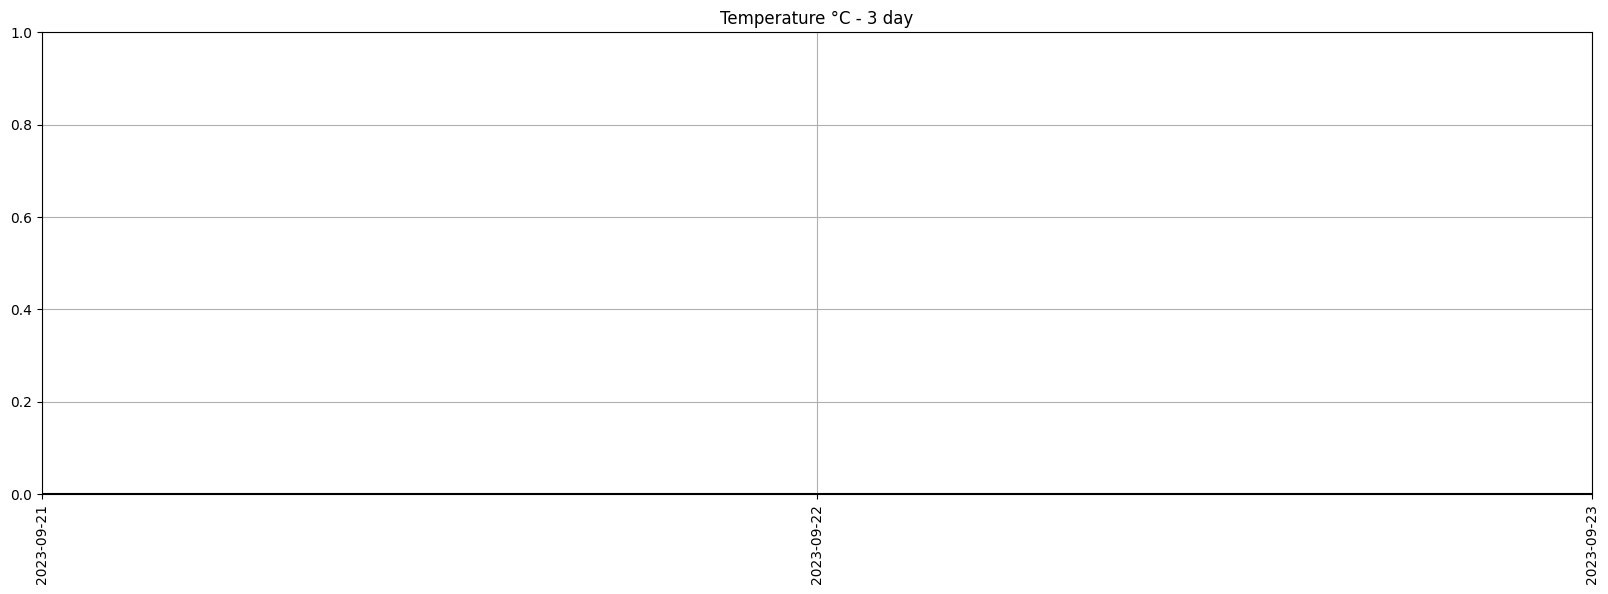

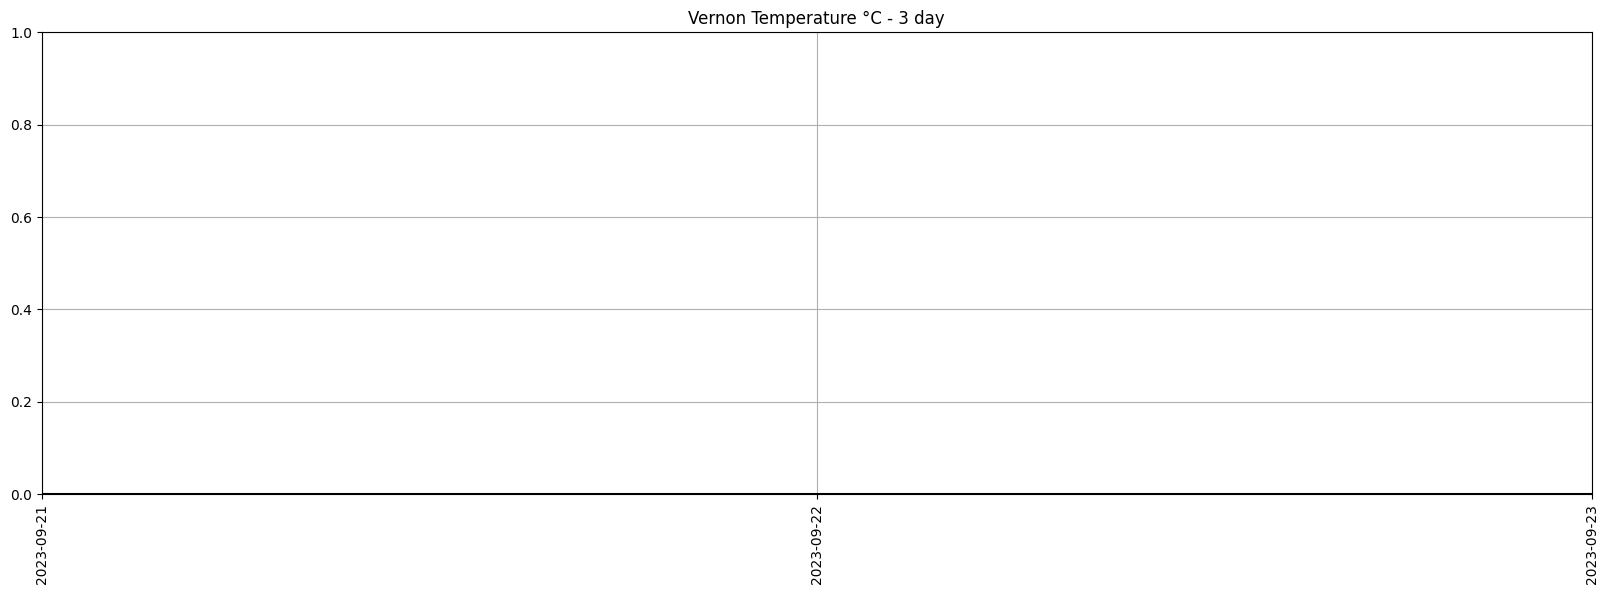

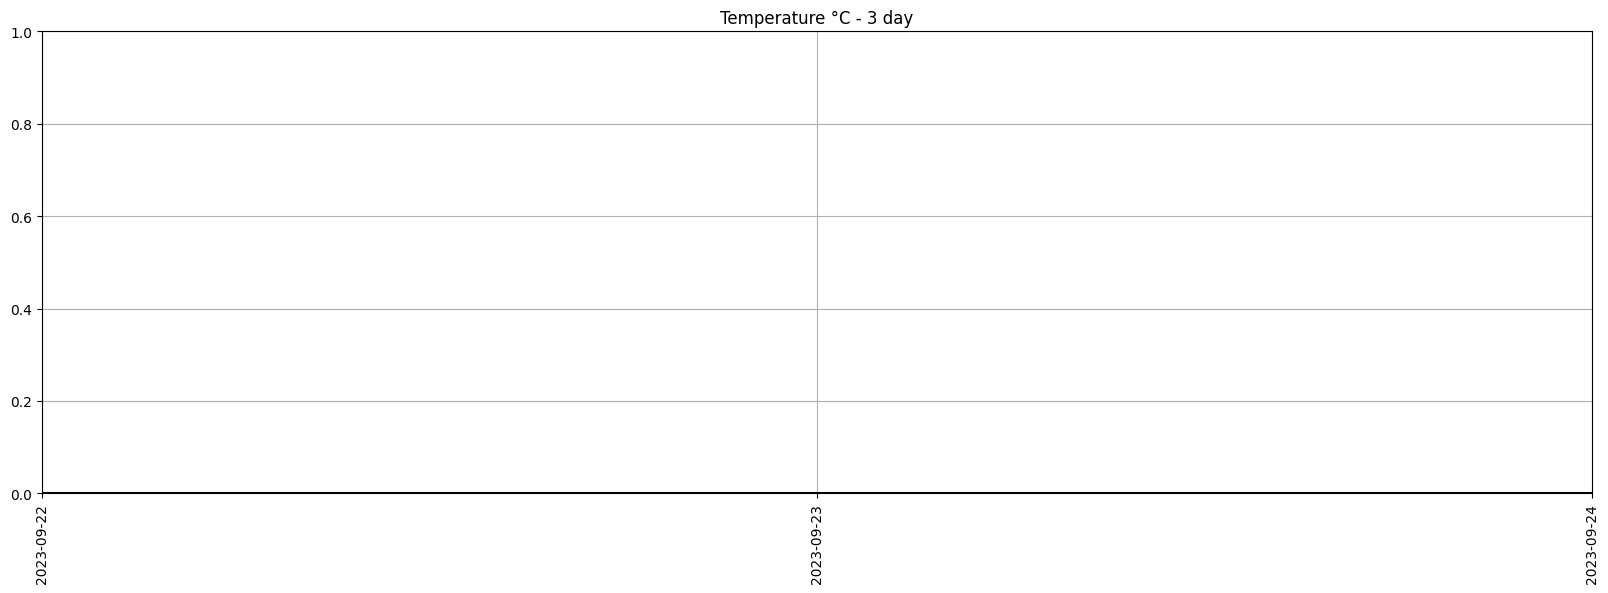

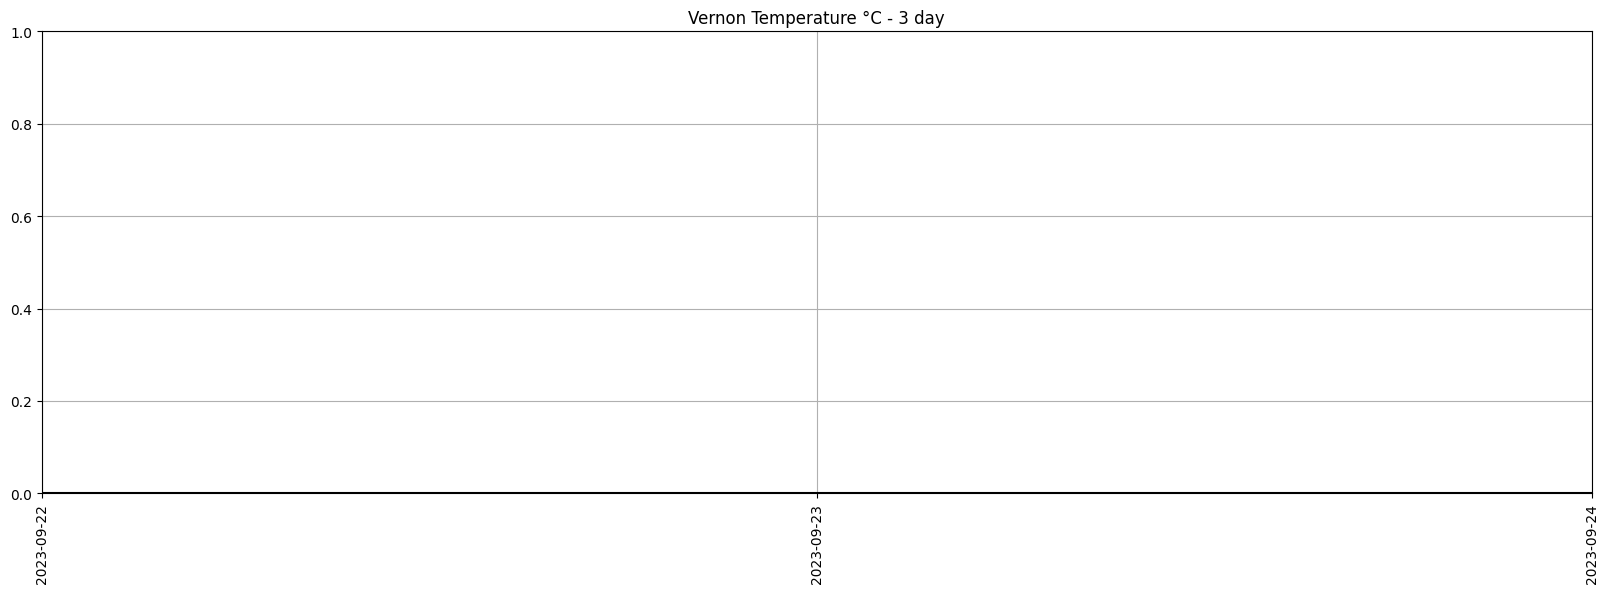

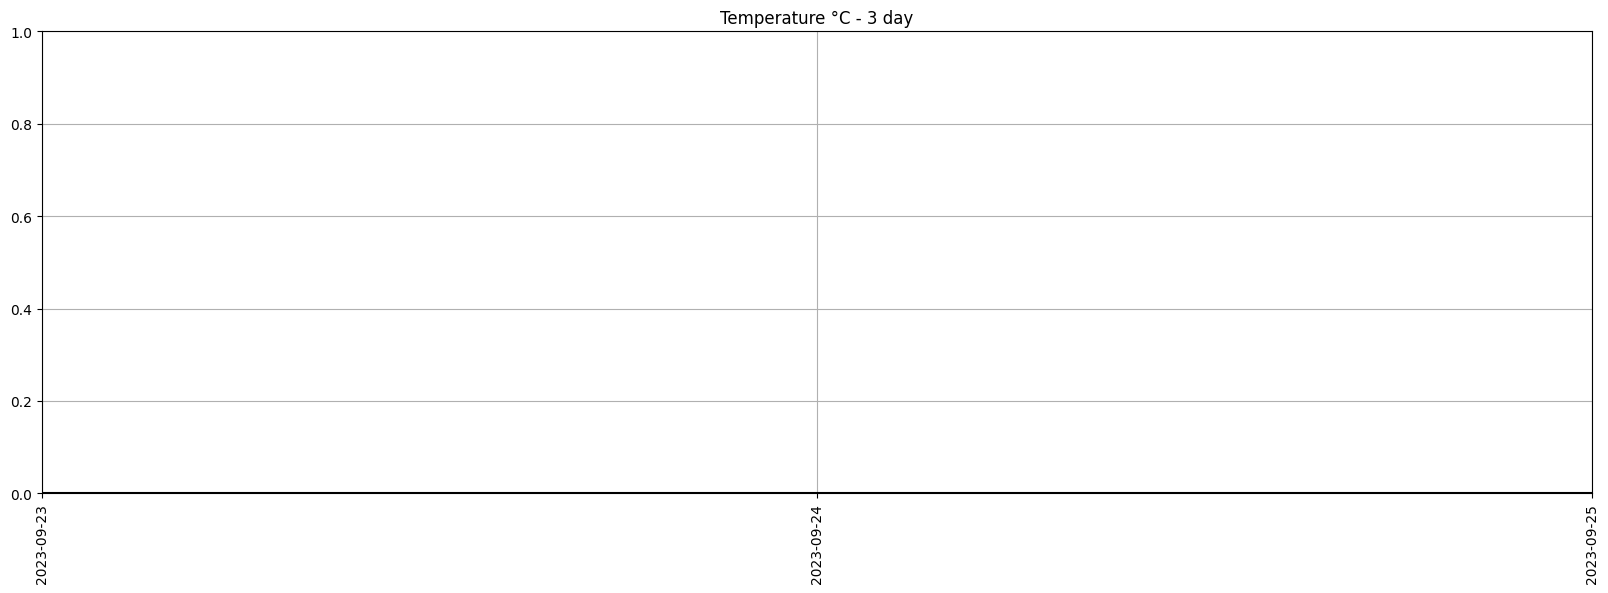

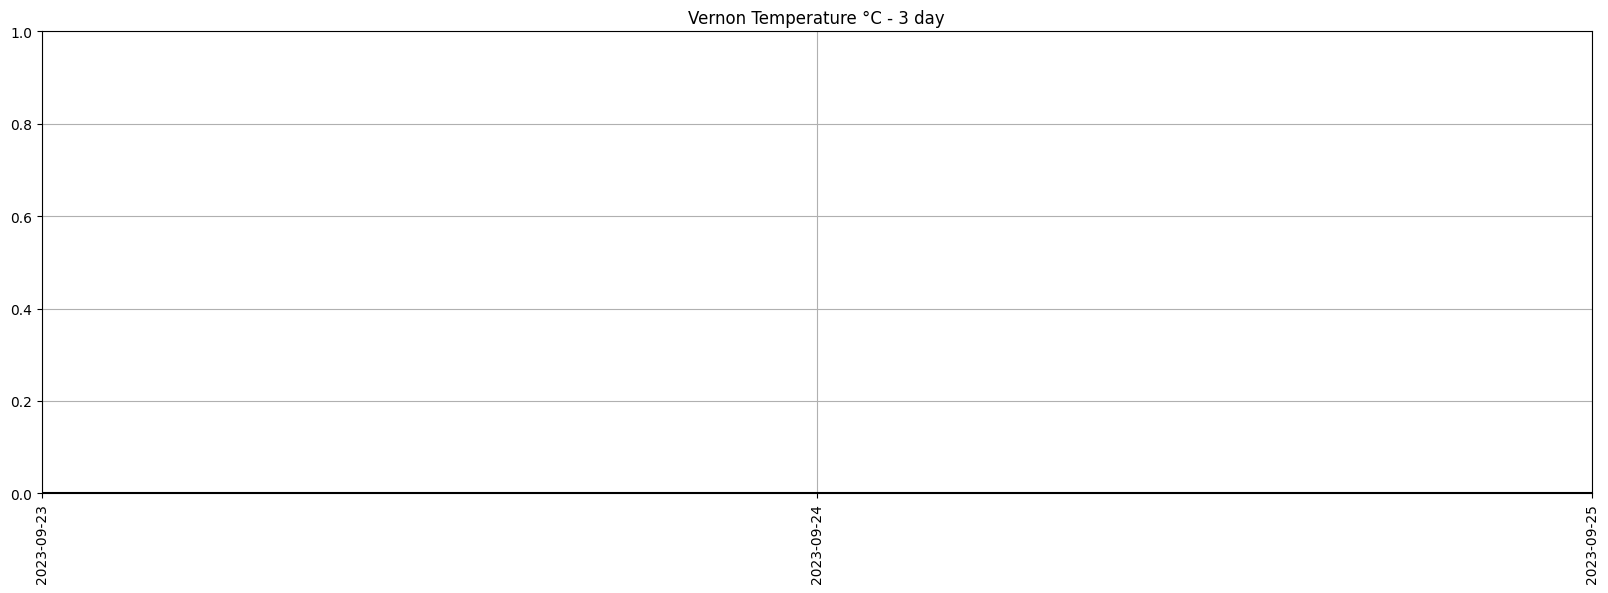

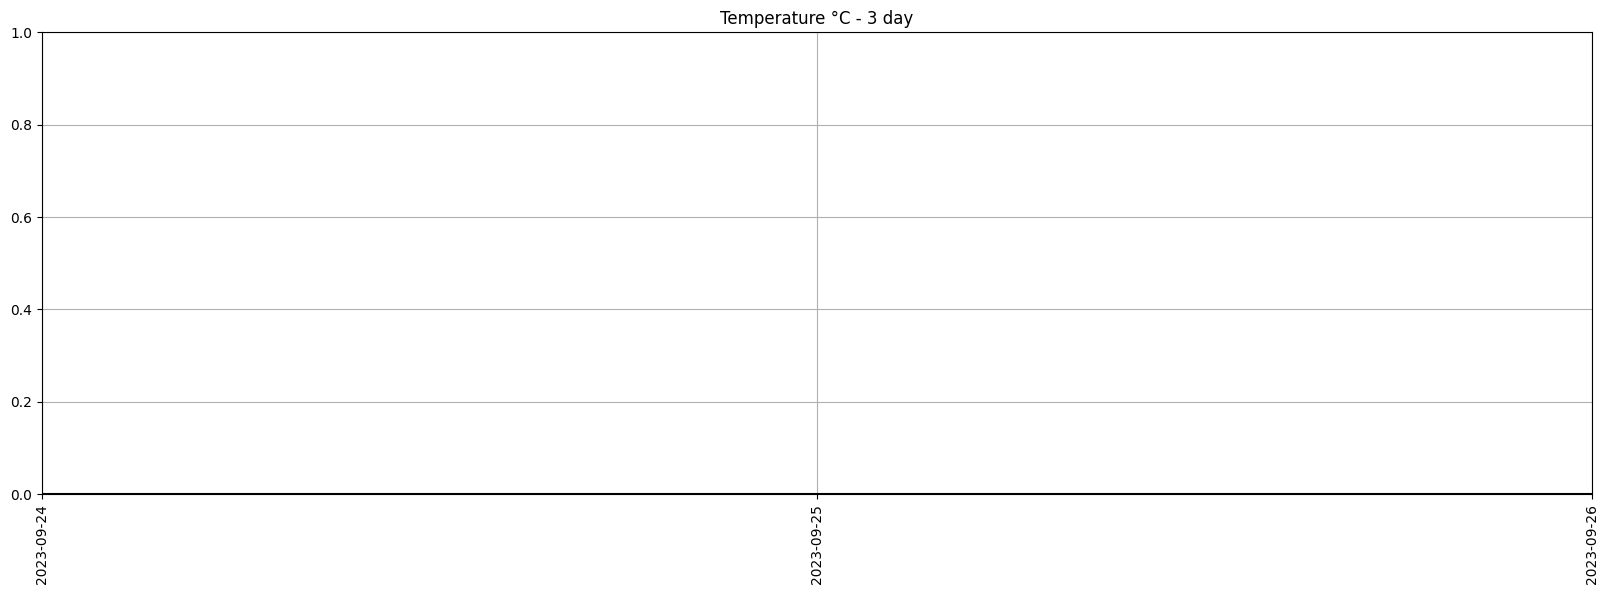

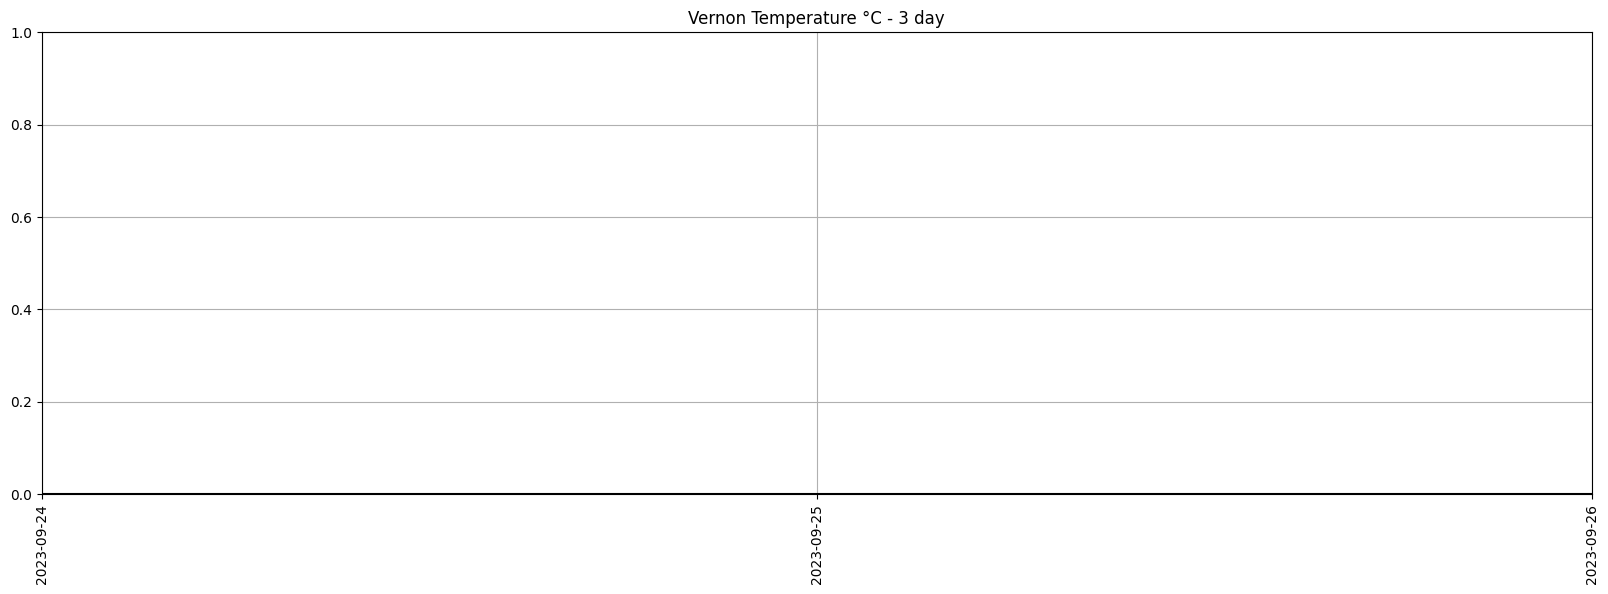

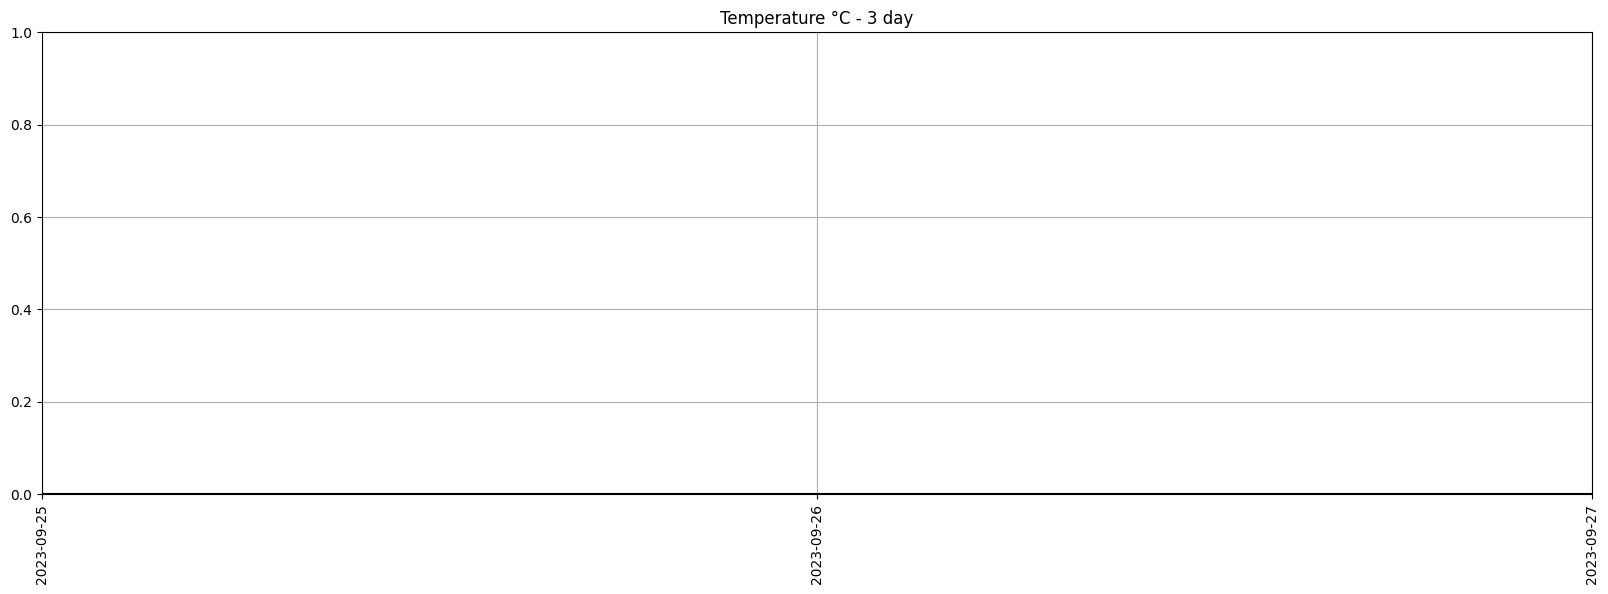

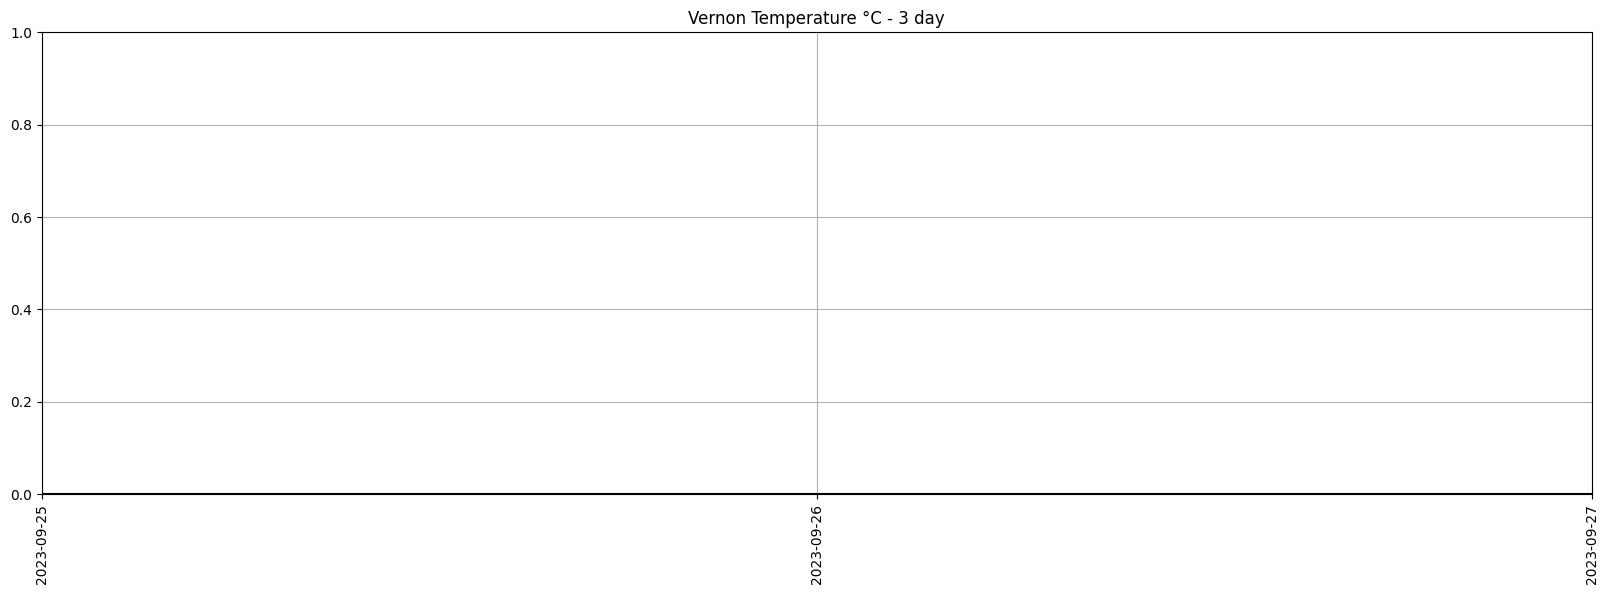

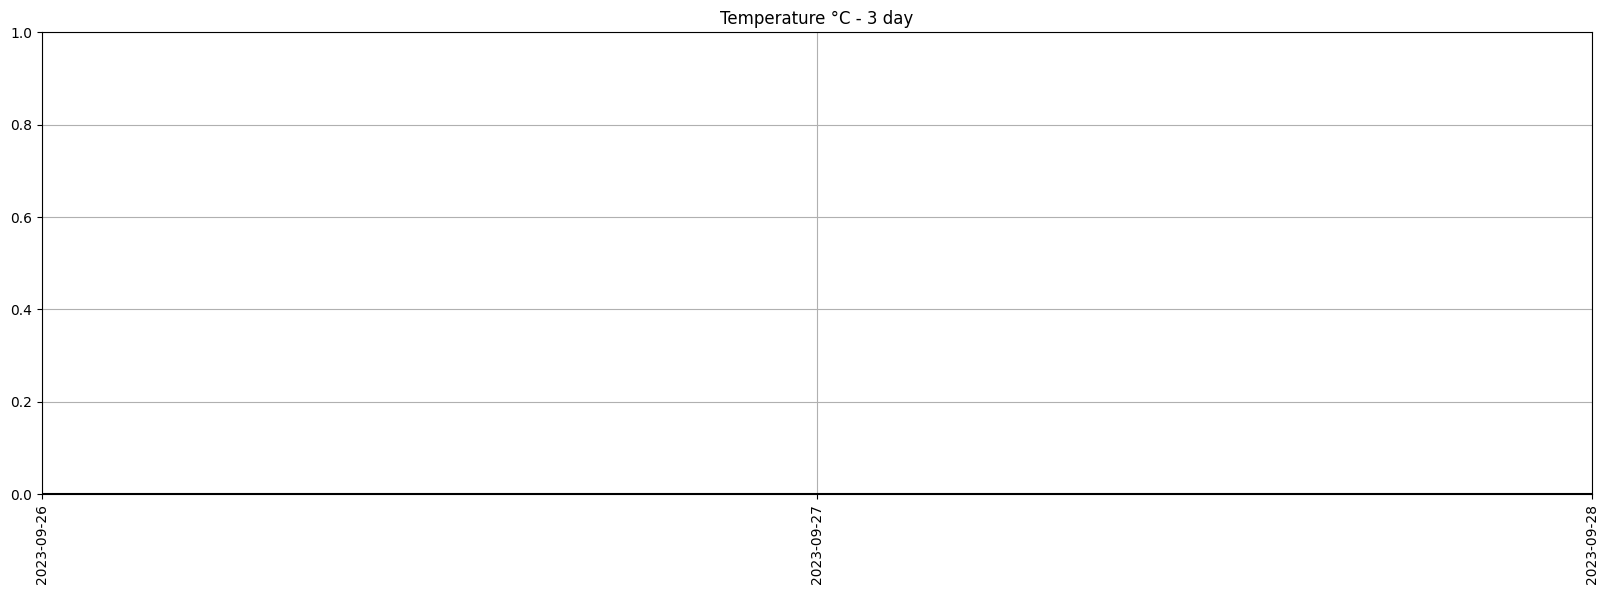

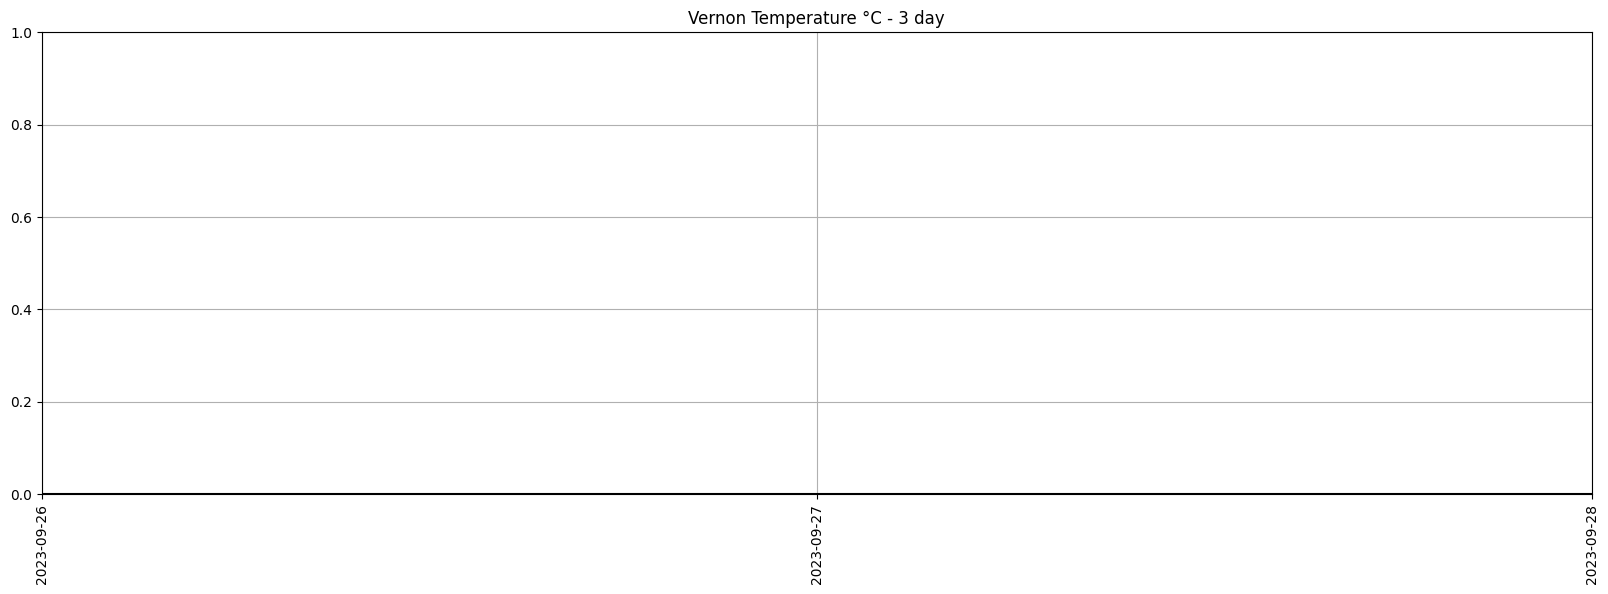

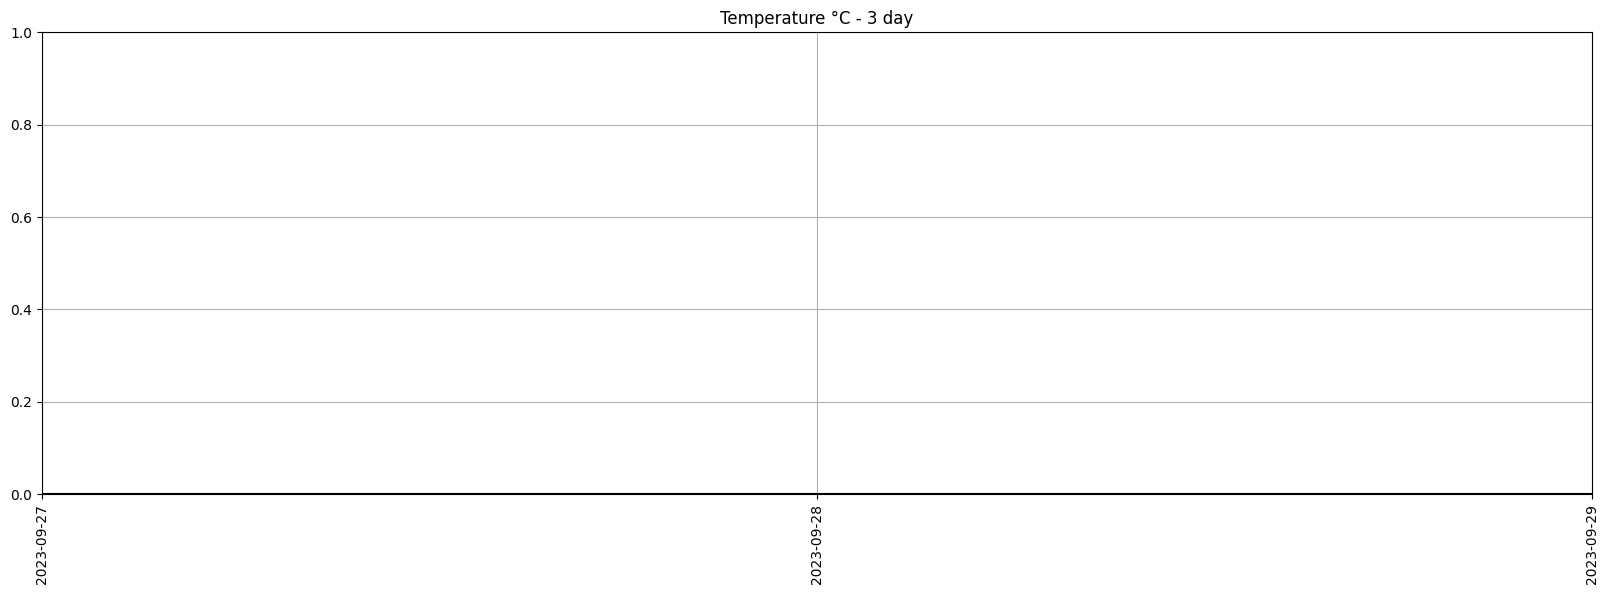

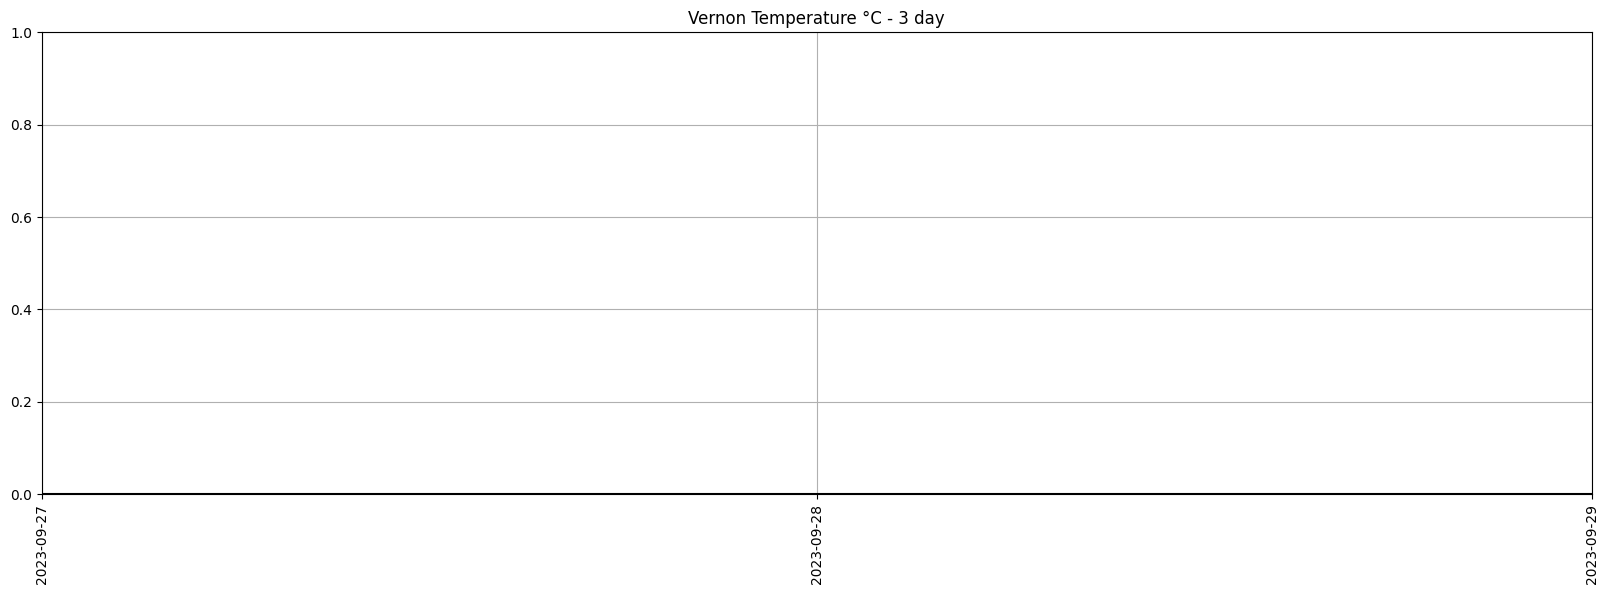

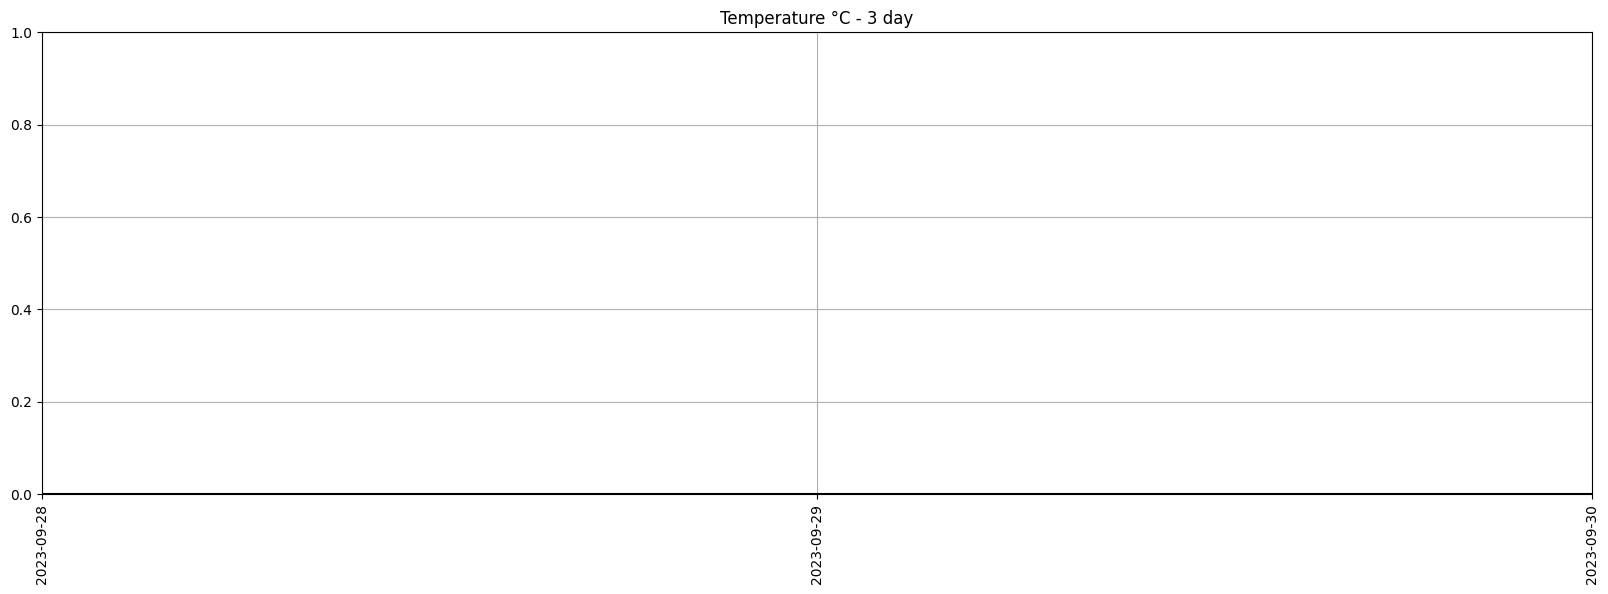

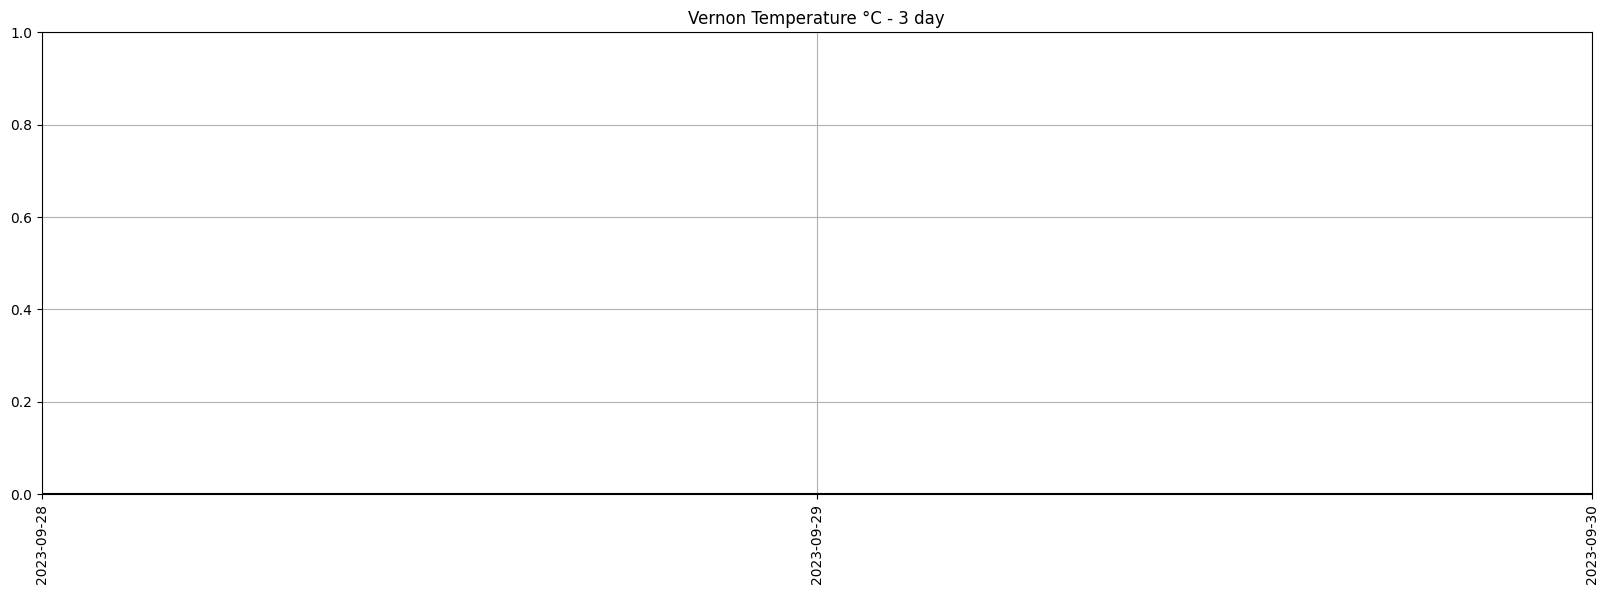

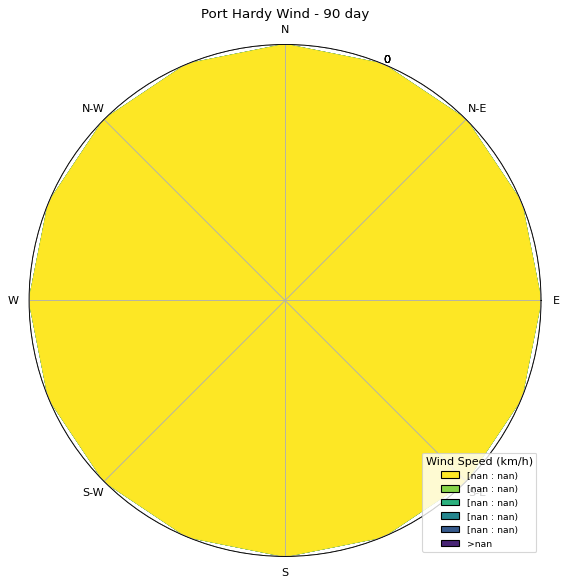

In [163]:
main()

In [148]:
weather_data = import_weather_data()

Patching Complete


In [153]:
for index, row in weather_data.iterrows():
    print("{}\n".format(row))

Date                         2020-01-01
Station                      Port Hardy
Pressure                            700
Height                           2856.0
Temp                               -4.3
DewPoint                           -5.8
Relative_Humidity                  89.0
Mean_Mixed_Layer                   3.56
Wind_Direction                    250.0
Wind_Speed                       87.044
Potential_Temp                    297.7
Equivalent_Potential_Temp         308.6
Virtual_Potential_Temp            298.3
Name: 3, dtype: object

Date                         2020-01-01
Station                      Port Hardy
Pressure                            850
Height                           1301.0
Temp                                3.4
DewPoint                            1.9
Relative_Humidity                  90.0
Mean_Mixed_Layer                   5.19
Wind_Direction                    250.0
Wind_Speed                       59.264
Potential_Temp                    289.7
Equivalent_Poten

Date                         2021-04-21
Station                          Vernon
Pressure                            850
Height                           1524.0
Temp                                7.6
DewPoint                          -10.4
Relative_Humidity                  27.0
Mean_Mixed_Layer                   2.05
Wind_Direction                     50.0
Wind_Speed                        3.704
Potential_Temp                    294.1
Equivalent_Potential_Temp         300.5
Virtual_Potential_Temp            294.5
Name: 2014, dtype: object

Date                         2021-04-22
Station                      Port Hardy
Pressure                            700
Height                           3068.0
Temp                               -2.7
DewPoint                          -11.7
Relative_Humidity                  50.0
Mean_Mixed_Layer                   2.24
Wind_Direction                    325.0
Wind_Speed                       66.672
Potential_Temp                    299.5
Equivalent_Po

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

